# Q1

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [241]:
#initialize one hot encode to get sequence features

def one_hot_encode_dna(sequence, kmer=1):
    encoding_map_1mer = {'A': '1000', 'C': '0100', 'G': '0010', 'T': '0001'}
    encoding_map_2mer = {
        'AA': '1000000000000000', 'AC': '0100000000000000', 'AG': '0010000000000000', 'AT': '0001000000000000',
        'CA': '0000100000000000', 'CC': '0000010000000000', 'CG': '0000001000000000', 'CT': '0000000100000000',
        'GA': '0000000010000000', 'GC': '0000000001000000', 'GG': '0000000000100000', 'GT': '0000000000010000',
        'TA': '0000000000001000', 'TC': '0000000000000100', 'TG': '0000000000000010', 'TT': '0000000000000001'
    }

    encoded_sequence = ''

    if kmer == 1:
        for nucleotide in sequence:
            encoded_sequence += encoding_map_1mer[nucleotide]
    elif kmer == 2:
        for i in range(len(sequence) - 1):
            dinucleotide = sequence[i:i + 2]
            encoded_sequence += encoding_map_2mer[dinucleotide]

    return [int(item) for item in list(encoded_sequence)]

In [242]:
# get 1mer and 2mer feature vectors

# max vector

max_df = pd.read_csv('max.txt', sep='\t', header=None)
max_df.columns = ['sequence', 'binding_strength']
sequences = max_df['sequence'].tolist()

max_1mer = np.array([one_hot_encode_dna(seq, 1) for seq in sequences])
max_2mer = np.array([one_hot_encode_dna(seq, 2) for seq in sequences])

# max normalized values

values = max_df['binding_strength'].tolist()

min_value = min(values)
max_value = max(values)
y = [(x - min_value) / (max_value - min_value) for x in values]
max_values = np.array(y)

# mad vector

mad_df = pd.read_csv('mad.txt', sep='\t', header=None)
mad_df.columns = ['sequence', 'binding_strength']
sequences = mad_df['sequence'].tolist()

mad_1mer = np.array([one_hot_encode_dna(seq, 1) for seq in sequences])
mad_2mer = np.array([one_hot_encode_dna(seq, 2) for seq in sequences])

# mad normalized values

values = mad_df['binding_strength'].tolist()

min_value = min(values)
max_value = max(values)
y = [(x - min_value) / (max_value - min_value) for x in values]
mad_values = np.array(y)

# myc vector

myc_df = pd.read_csv('myc.txt', sep='\t', header=None)
myc_df.columns = ['sequence', 'binding_strength']
sequences = myc_df['sequence'].tolist()

myc_1mer = np.array([one_hot_encode_dna(seq, 1) for seq in sequences])
myc_2mer = np.array([one_hot_encode_dna(seq, 2) for seq in sequences])

# myc normalized values

values = myc_df['binding_strength'].tolist()

min_value = min(values)
max_value = max(values)
y = [(x - min_value) / (max_value - min_value) for x in values]
myc_values = np.array(y)

In [243]:
# get 1mer + shape feature vectors using given shape data

features = ['HelT', 'MGW', 'ProT', 'Roll']

max_shape = max_1mer
mad_shape = mad_1mer
myc_shape = myc_1mer

# max

for feat in features:
    df = pd.read_csv('dna_shapes/Max.' + feat, sep = ' ', header = None)
    featlist = np.array(df)
    max_shape = np.append(max_shape, featlist, axis=1)

# mad

for feat in features:
    df = pd.read_csv('dna_shapes/Mad.' + feat, sep = ' ', header = None)
    featlist = np.array(df)
    mad_shape = np.append(mad_shape, featlist, axis=1)

# myc

for feat in features:
    df = pd.read_csv('dna_shapes/Myc.' + feat, sep = ' ', header = None)
    featlist = np.array(df)
    myc_shape = np.append(myc_shape, featlist, axis=1)

## Q2

In [244]:
# 1mer

tfs = ['max', 'mad', 'myc']

R2_1mer = []
R2_2mer = []
R2_shape = []

for tf in tfs:

    X_1mer = eval(tf + '_1mer')
    X_2mer = eval(tf + '_2mer')
    X_shape = eval(tf + '_shape')
    
    y = eval(tf + '_values')
    
    # Cross-validation
    cv = KFold(n_splits=10, shuffle=True, random_state=1)

    # Q5: Regularization
    # Any choice of L1, L2, or Elastic Net is fine, as long as the explanation is sensible.
    # For the lambda in the regularization parameter, you can determine the optimal value by either using a
    # grid search approach or employing a method by manualy setting several reseaonable hyperparameters.

    model_1mer = Ridge(alpha=0.001)
    model_2mer = Ridge(alpha=0.001)
    model_shape = Ridge(alpha=0.001)

    # results
    r_squared_1mer_scores = []
    r_squared_2mer_scores = []
    r_squared_shape_scores = []

    # Loop over each fold
    fold = 1
    for train_index, valid_index in cv.split(y):
        # Split data
        X_1mer_train, X_1mer_valid = X_1mer[train_index], X_1mer[valid_index]
        X_2mer_train, X_2mer_valid = X_2mer[train_index], X_2mer[valid_index]
        X_shape_train, X_shape_valid = X_shape[train_index], X_shape[valid_index]
        
        y_train, y_valid = y[train_index], y[valid_index]
        
        # Fit the model
        model_1mer.fit(X_1mer_train, y_train)
        model_2mer.fit(X_2mer_train, y_train)
        model_shape.fit(X_shape_train, y_train)

        # Predict on valid set
        predictions_1mer = model_1mer.predict(X_1mer_valid)
        predictions_2mer = model_2mer.predict(X_2mer_valid)
        predictions_shape = model_shape.predict(X_shape_valid)

        # Evaluate the model

        r_squared_1mer = r2_score(y_valid, predictions_1mer)
        r_squared_1mer_scores.append(r_squared_1mer)
        
        r_squared_2mer = r2_score(y_valid, predictions_2mer)
        r_squared_2mer_scores.append(r_squared_2mer)

        r_squared_shape = r2_score(y_valid, predictions_shape)
        r_squared_shape_scores.append(r_squared_shape)

        fold += 1

    R2_1mer.append(r_squared_1mer_scores)
    R2_2mer.append(r_squared_2mer_scores)
    R2_shape.append(r_squared_shape_scores)

    average_r_squared_1mer = np.mean(r_squared_1mer_scores)
    average_r_squared_2mer = np.mean(r_squared_2mer_scores)
    average_r_squared_shape = np.mean(r_squared_shape_scores)

    print(f'TF {tf} Average r_squared 1mer: {average_r_squared_1mer}')
    print(f'TF {tf} Average r_squared 2mer: {average_r_squared_2mer}')
    print(f'TF {tf} Average r_squared 1mer + shape: {average_r_squared_shape}')
    print('')

TF max Average r_squared 1mer: 0.7845132686317624
TF max Average r_squared 2mer: 0.8647202578196088
TF max Average r_squared 1mer + shape: 0.9273563119349711

TF mad Average r_squared 1mer: 0.7738834550439663
TF mad Average r_squared 2mer: 0.8538236792234105
TF mad Average r_squared 1mer + shape: 0.9491785934218262

TF myc Average r_squared 1mer: 0.7779846788408209
TF myc Average r_squared 2mer: 0.8344220328411867
TF myc Average r_squared 1mer + shape: 0.9125729053614261



# Q3

Text(0, 0.5, 'R^2 for 1mer + shape')

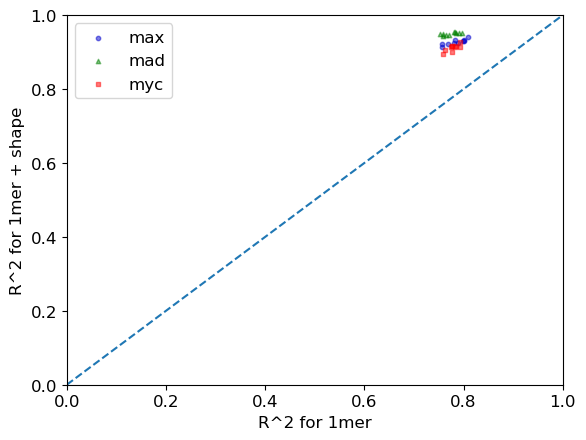

In [254]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(R2_1mer[0], R2_shape[0], c='mediumblue', s=10, marker = 'o', alpha = .5)
ax1.scatter(R2_1mer[1], R2_shape[1], c='green', s=10, marker = '^', alpha = .5)
ax1.scatter(R2_1mer[2], R2_shape[2], c='red', s=10, marker = 's', alpha = .5)
ax1.legend(['max', 'mad', 'myc'])
ax1.plot([0,1],[0,1],'--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('R^2 for 1mer')
plt.ylabel('R^2 for 1mer + shape')

Text(0, 0.5, 'R^2 for 1mer + shape')

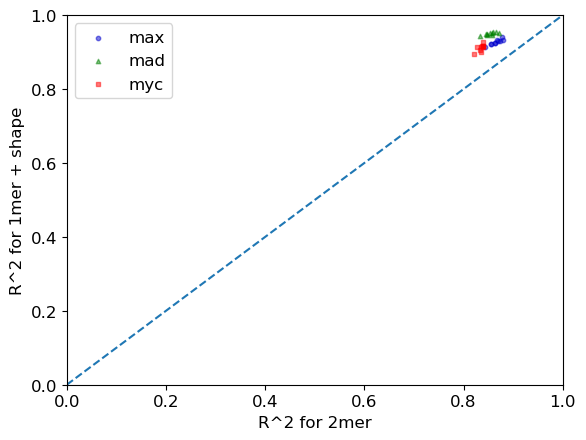

In [255]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(R2_2mer[0], R2_shape[0], c='mediumblue', s=10, marker = 'o', alpha = .5)
ax1.scatter(R2_2mer[1], R2_shape[1], c='green', s=10, marker = '^', alpha = .5)
ax1.scatter(R2_2mer[2], R2_shape[2], c='red', s=10, marker = 's', alpha = .5)
ax1.legend(['max', 'mad', 'myc'])
ax1.plot([0,1],[0,1],'--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('R^2 for 2mer')
plt.ylabel('R^2 for 1mer + shape')

From the results, we see that 1mer + shape does significantly better than both 2mer and 1mer, as we would expect from our class lectures.

We knew from assignment 1 that 2mer performs better than 1mer, but it's interesting to see that 1mer with shape does far better than 2mer. This shows the important advantages of using shape features along with sequence data rather than simply using sequence features. The 3D knowledge gives a big edge in predicting binding strength for these TFs.

# Q4

In [225]:
def parse_fasta(file_path, label):
    sequences = []
    with open(file_path, 'r') as file:
        for line in file:
            if not line.startswith('>'):
                sequences.append((line.strip()))
    return pd.DataFrame({'sequence': sequences, 'label': label})

In [226]:
# get 1mer and 2mer feature vectors

# ctcf_bound vector

bound_df = parse_fasta('ctcf_bound.fasta', 1)
sequences = bound_df['sequence'].tolist()
bvals = bound_df['label'].tolist()

bound_1mer = np.array([one_hot_encode_dna(seq, 1) for seq in sequences])
bound_2mer = np.array([one_hot_encode_dna(seq, 2) for seq in sequences])

# ctcf_unbound vector

unbound_df = parse_fasta('ctcf_unbound.fasta',0)
sequences = unbound_df['sequence'].tolist()
uvals = unbound_df['label'].tolist()

unbound_1mer = np.array([one_hot_encode_dna(seq, 1) for seq in sequences])
unbound_2mer = np.array([one_hot_encode_dna(seq, 2) for seq in sequences])

In [227]:
# get 1mer + shape feature vectors using given shape data

features = ['HelT', 'MGW', 'ProT', 'Roll']

bound_shape = bound_1mer
unbound_shape = unbound_1mer

# bound

for feat in features:
    df = pd.read_csv('dna_shapes/ctcf_bound.' + feat, sep = ' ', header = None)
    featlist = np.array(df)
    bound_shape = np.append(bound_shape, featlist, axis=1)
    
# unbound

for feat in features:
    df = pd.read_csv('dna_shapes/ctcf_unbound.' + feat, sep = ' ', header = None)
    featlist = np.array(df)
    unbound_shape = np.append(unbound_shape, featlist, axis=1)

In [232]:
# logistic regression

types = ['_1mer', '_2mer', '_shape']

X_1mer = np.append(bound_1mer, unbound_1mer, axis=0)
X_2mer = np.append(bound_2mer, unbound_2mer, axis=0)
X_shape = np.append(bound_shape, unbound_shape, axis=0)

bvals, uvals = np.array(bvals), np.array(uvals)
y = np.append(bvals,uvals)

all_tprs = []

for type in types:

    model = LogisticRegression(solver='newton-cholesky')
    cv = StratifiedKFold(n_splits=10)
    
    auroc_scores = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    X = eval('X' + type)
    
    for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
    
            model.fit(X_train, y_train)
            auroc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
            auroc_scores.append(auroc)
    
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0

    all_tprs.append(tprs)

    average_auroc = np.mean(auroc_scores)
    print(f"Average AUROC for ctcf{type}: {average_auroc}")

Average AUROC for ctcf_1mer: 0.9549175
Average AUROC for ctcf_2mer: 0.9415175000000001
Average AUROC for ctcf_shape: 0.9500525


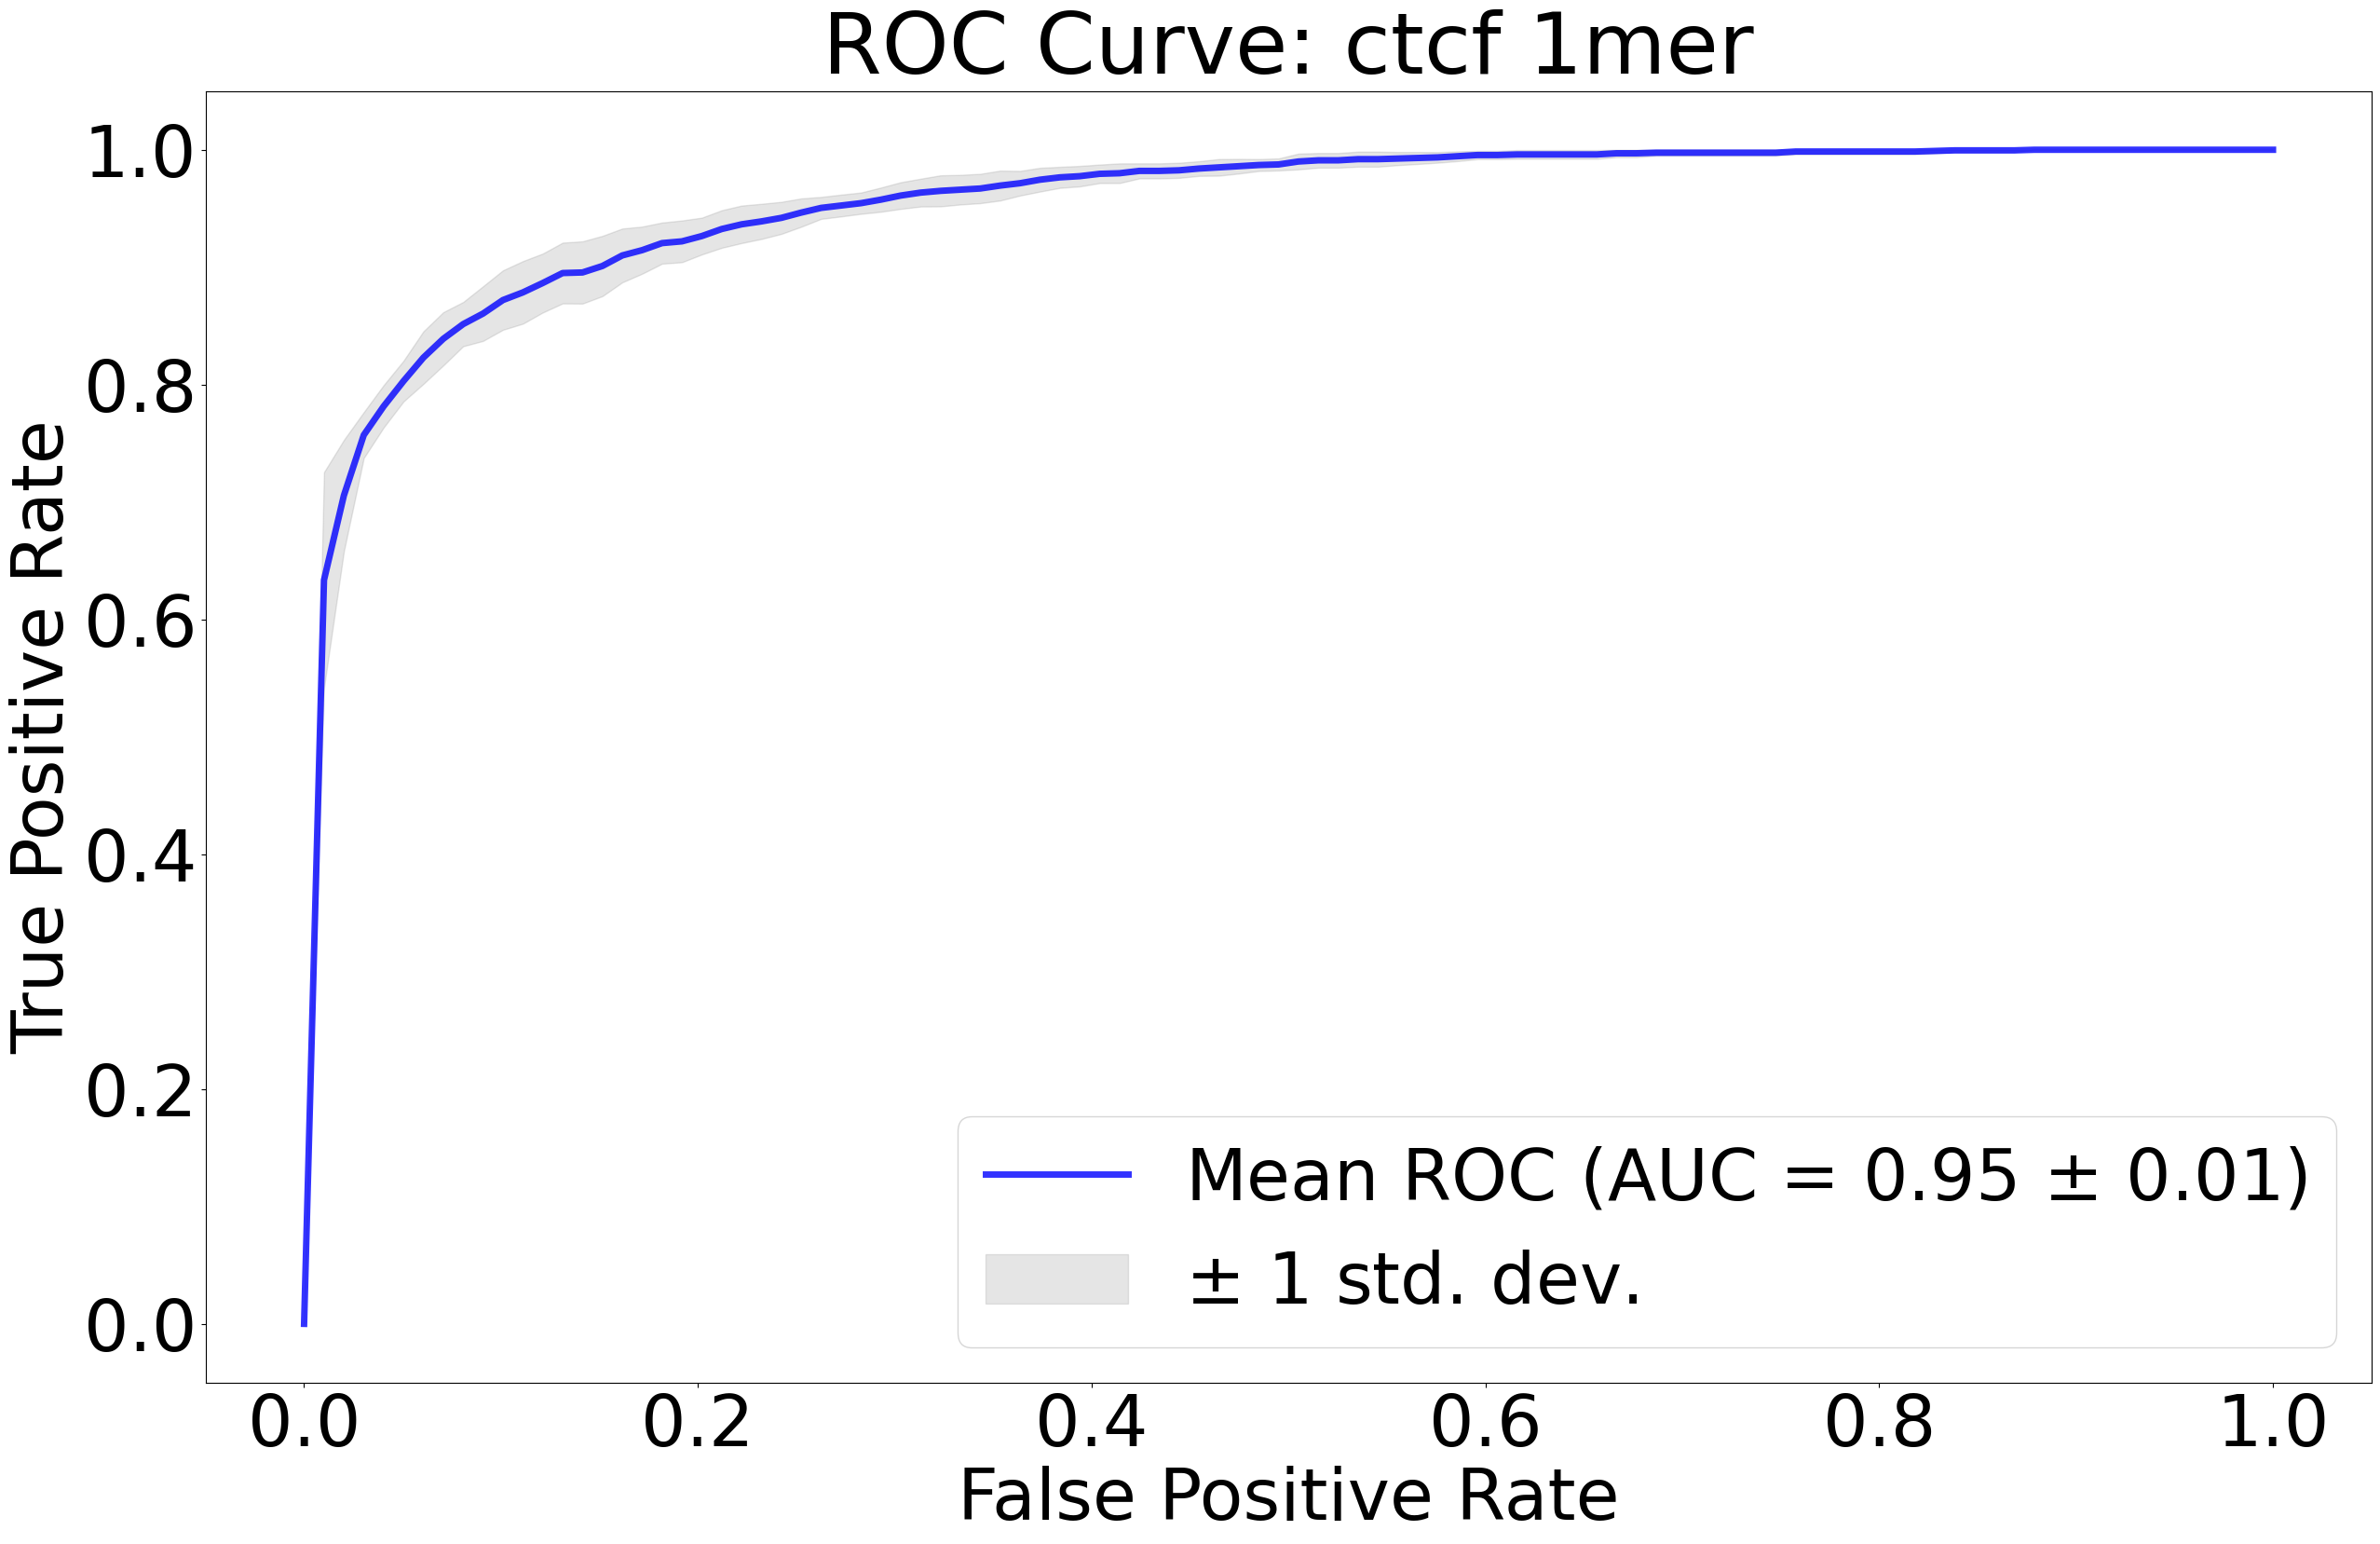

------
------


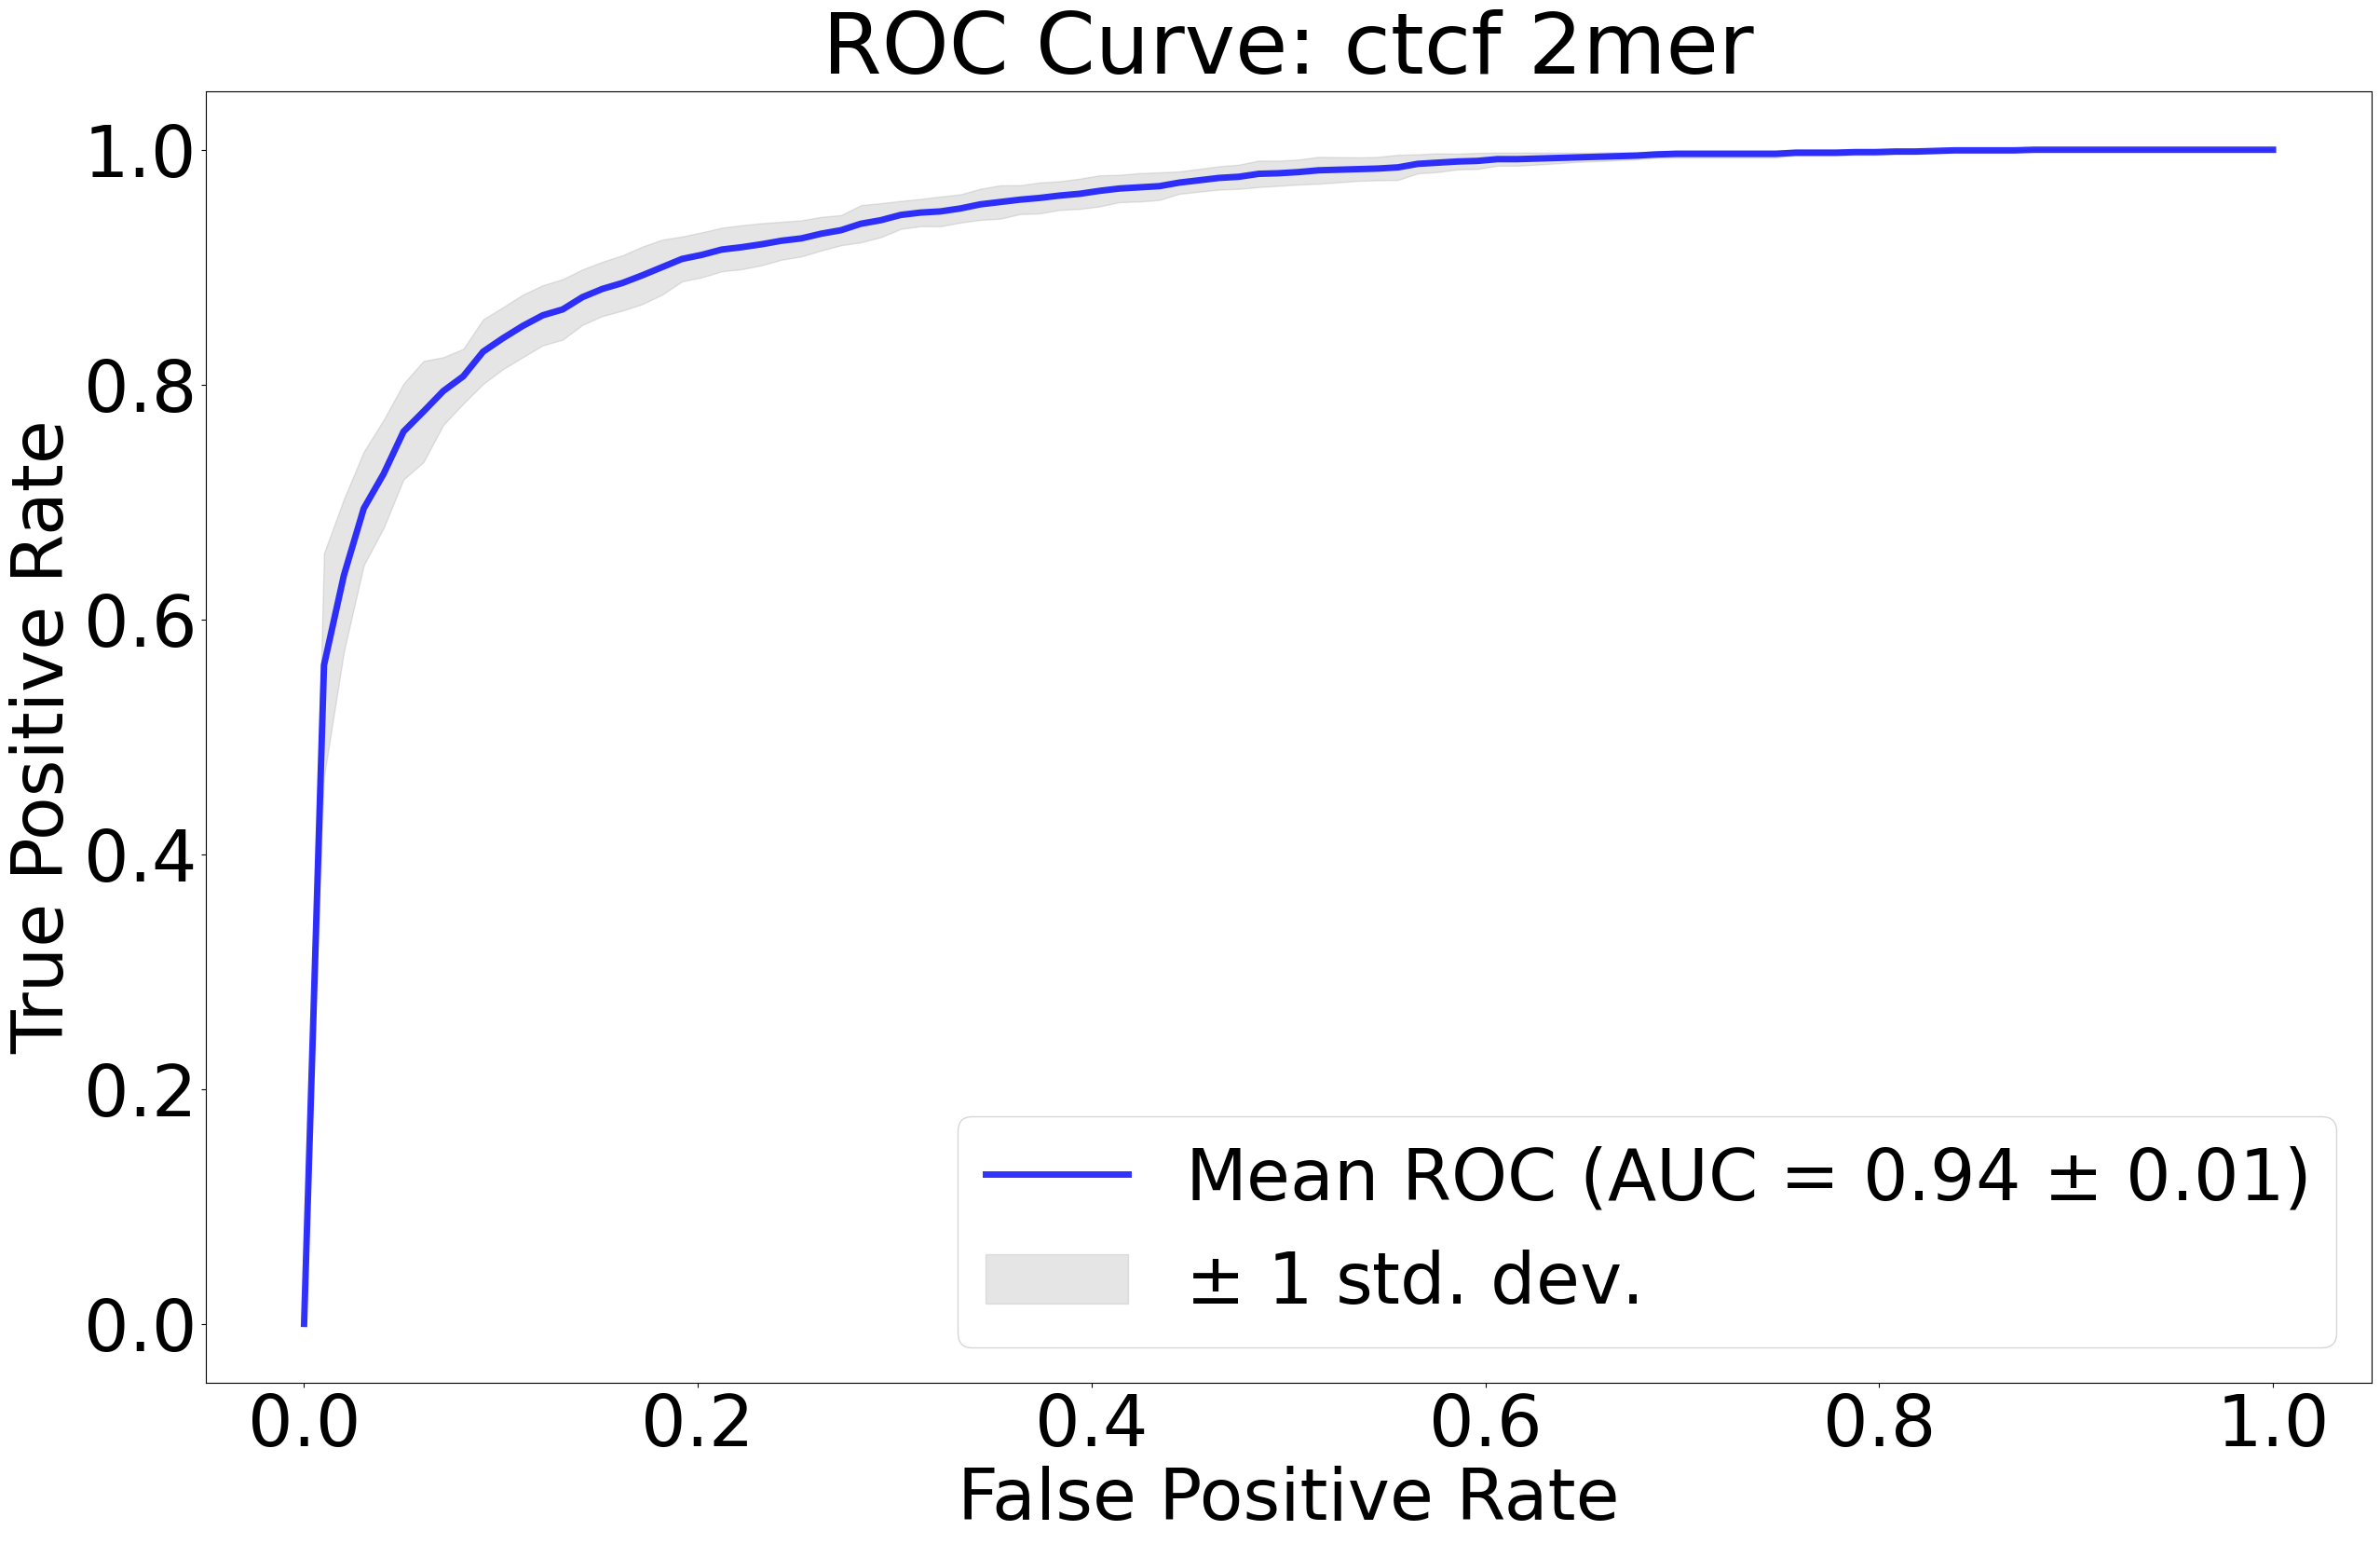

------
------


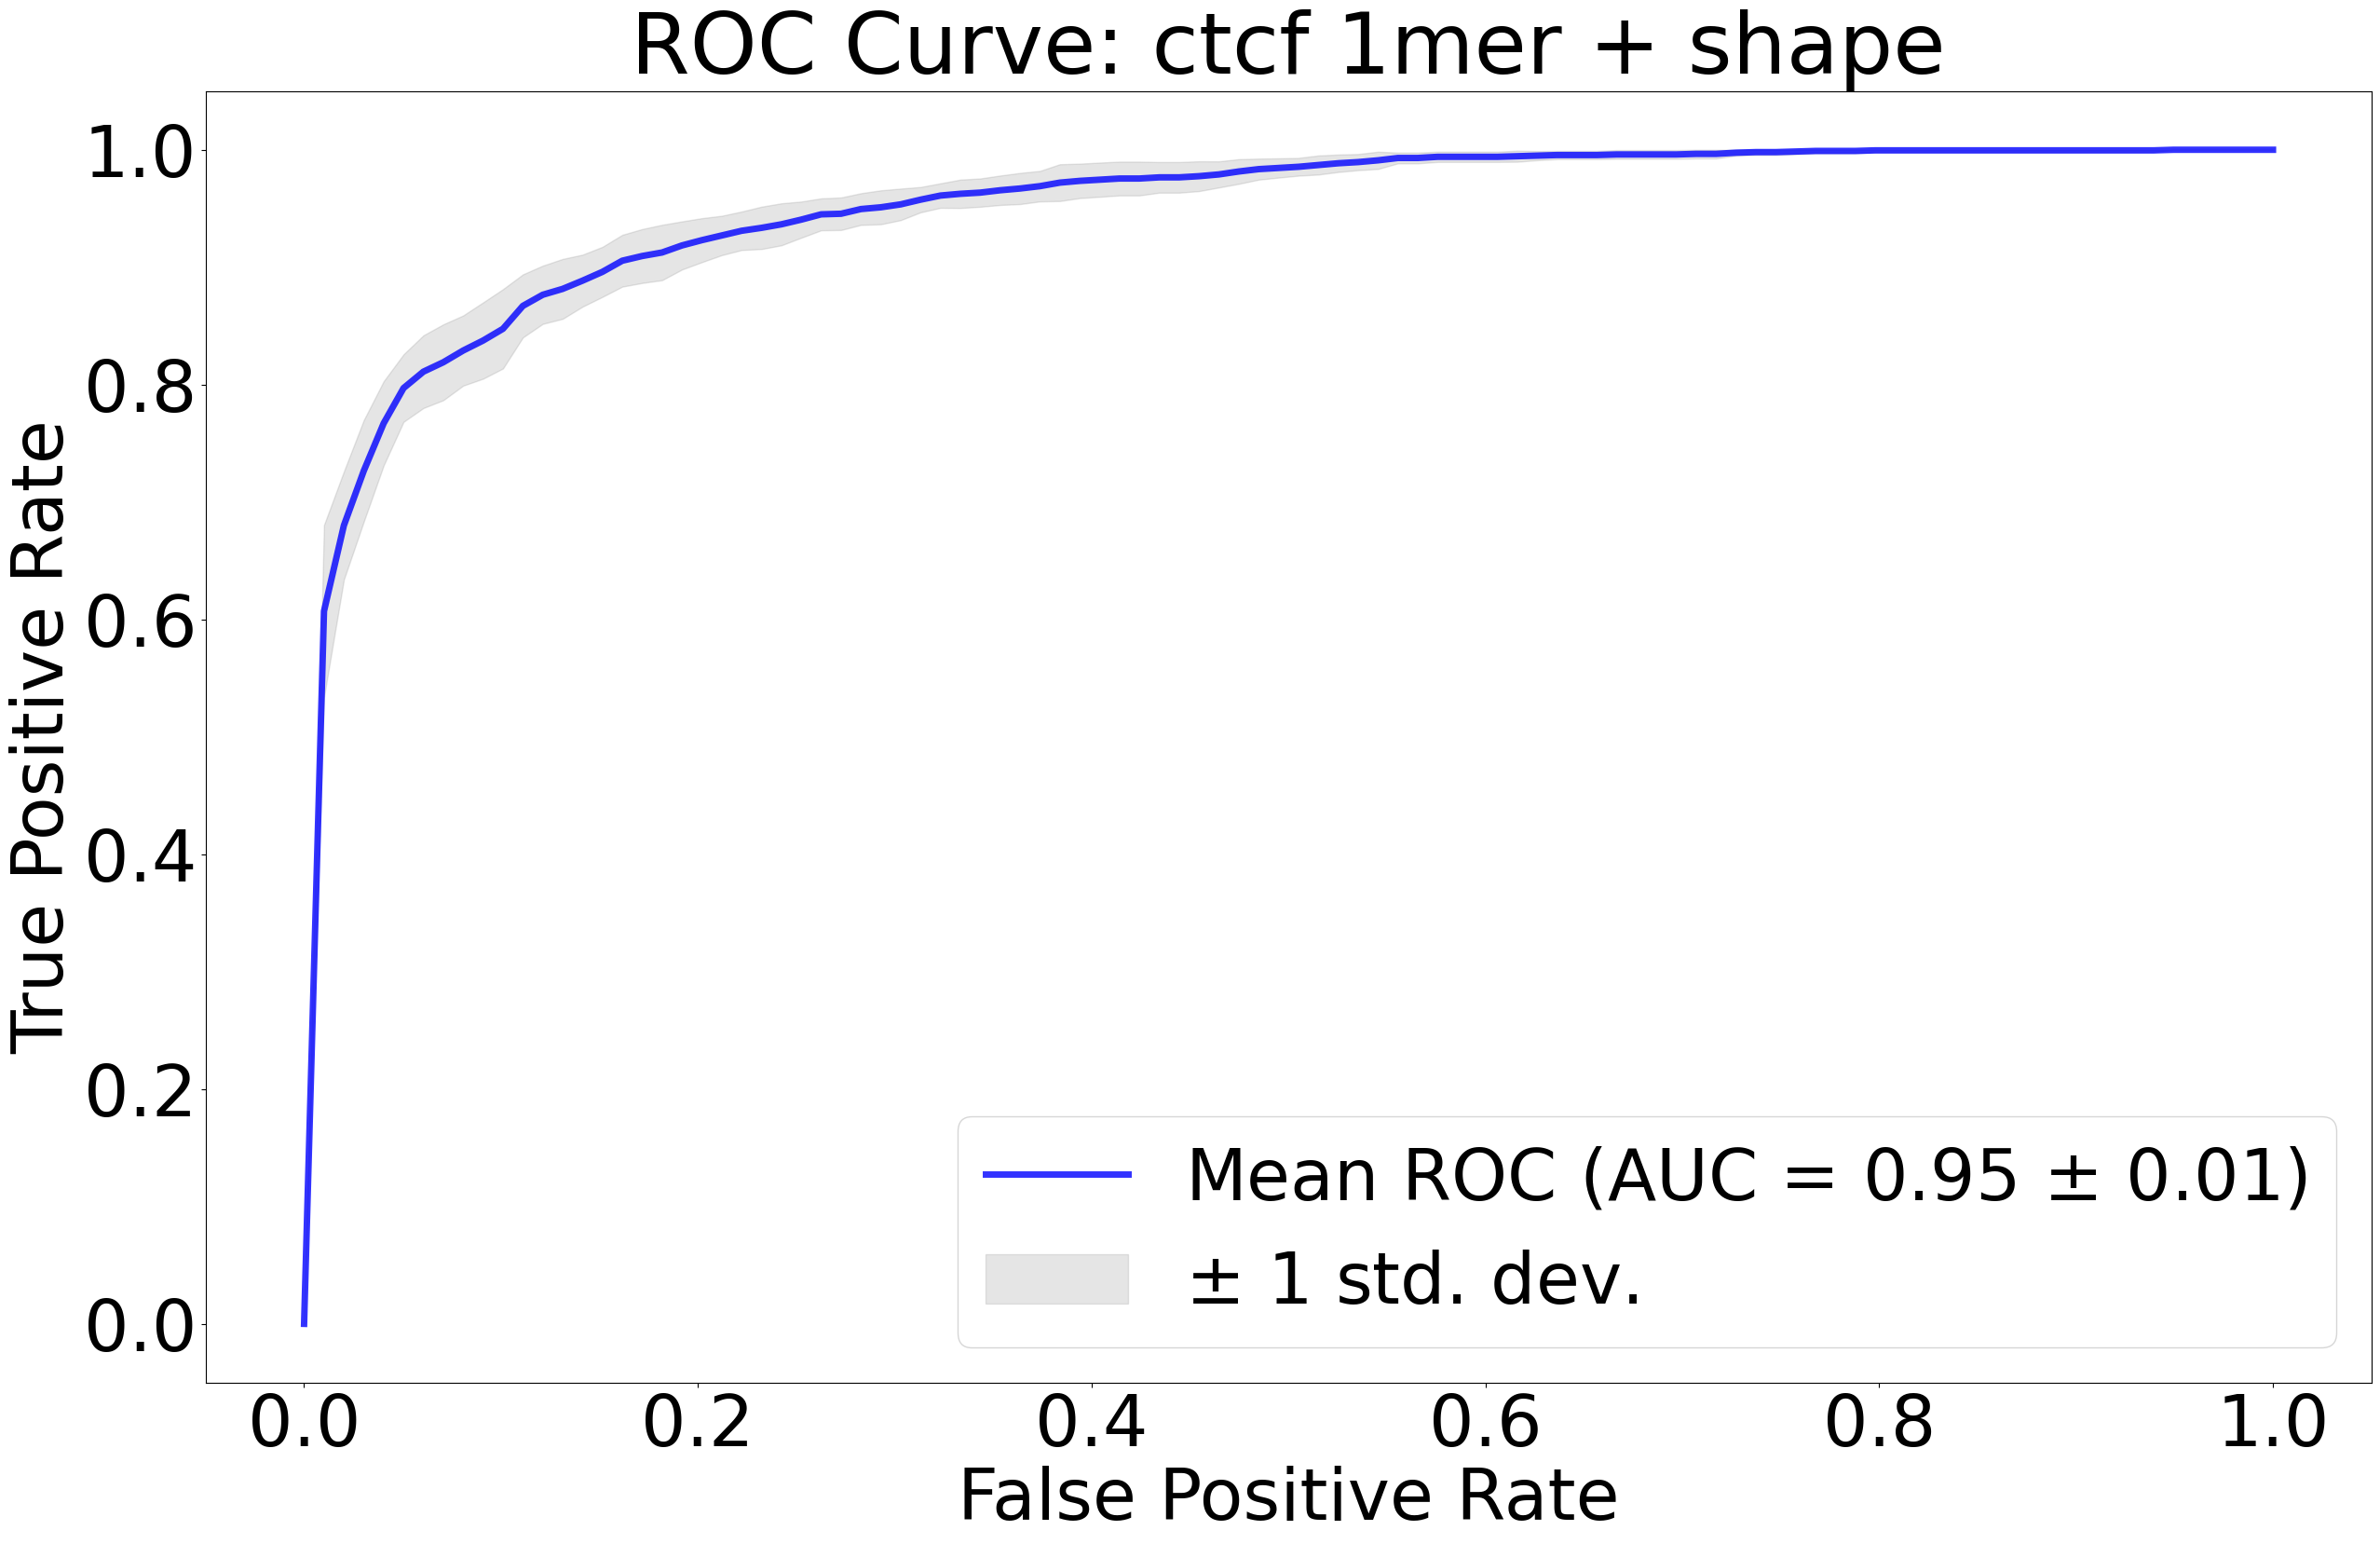

In [259]:
def plot_auroc(tprs, tf_name):
    # Calculate mean and standard deviation of the ROC curve

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(auroc_scores)

    # Plot the mean ROC curve
    fontsize = 55
    plt.rcParams.update({'font.size': fontsize})
    plt.figure(figsize=(30, 18))
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=5, alpha=.8)

    # Plot the standard deviation around the mean ROC curve
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: ' + tf_name)
    plt.legend(loc="lower right")
    plt.show()

plot_auroc(all_tprs[0], "ctcf 1mer")
print('------')
print('------')
plot_auroc(all_tprs[1], "ctcf 2mer")
print('------')
print('------')
plot_auroc(all_tprs[2], "ctcf 1mer + shape")

We have the 1mer case doing better than the 2mer case, similar to what we saw in Assignment 2. Unlike with the MLR problem, here we see 1mer performs slightly better than 1mer+shape, and 1mer+shape performs slightly better than 2mer. This seems to show that looking at simple 1mer sequence features actually offers the most effective way to look at ctcf binding, and that the 2mer and shape features just cloud the results with unnecessary data.

This leads to some possible hypotheses. Perhaps shape data is not as helpful for classification tasks as it is for classification tasks. Or, the results for CTCF are the exception and not the rule; that is, despite these results, in most cases shape data can help get better models/results even for classification.

If I had to guess, I'd say the latter is probably true since DNA shape data should be able to effectively help with understanding whether or not something will bind to DNA.